# <center> **Анализ результатов A/B-тестирования**

## **Краткое описание**

**В данном исследовании проводится оценка влияния нового продукта на конверсию бронирования и оплаты пользователем первой сессии с психологом Альтер (ga:goal18Completions).**

## **Определяем метрику**

**Оцениваем статистическую значимость изменения конверсии.**

### **Импортируем необходимые библиотеки**

In [4]:
import pandas as pd # работа с таблицами
import numpy as np # линейная алгебра
import seaborn as sns # графики и диаграммы
import matplotlib.pyplot as plt # графики и диаграммы
from statsmodels.stats.proportion import proportions_ztest # статистические тесты
from scipy.stats import norm # статистика

**Прочитаем наши данные**

In [5]:
ab_test = pd.read_csv('data/NovayaAnketa2022.csv')
ab_test.head()

,Variant,Date Hour and Minute,Source / Medium,City,Users,New Users,ga:goal11Completions,ga:goal12Completions,ga:goal18Completions
0,0,202210131452,yandex.ru / referral,Moscow,1,1,0,0,0
1,0,202210131453,google / organic,Sochi,1,1,0,0,0
2,0,202210131454,google / cpc,Brno,1,1,0,0,0
3,0,202210131455,google / cpc,Brno,1,0,0,0,0
4,0,202210131455,google / organic,Moscow,1,0,0,0,0


In [6]:
def optimize_users(df, users_col, goal_col):
    new_rows = []
    for index, row in df.iterrows():
        for i in range(row[users_col]):
            if i < row[goal_col]:
                new_row = row.copy()
                new_row[users_col] = 1
                new_row[goal_col] = 1
                new_rows.append(new_row)
            else:
                new_row = row.copy()
                new_row[users_col] = 1
                new_row[goal_col] = 0
                new_rows.append(new_row)
    new_df = pd.DataFrame(new_rows, )
    return new_df.reset_index(drop=True)

ab_test = optimize_users(ab_test, 'Users', 'ga:goal18Completions')

**Приведем столбец Date Hour and Minute к формату to_datetime для работы с датами, а также создадим отдельный столбец с датой**

In [7]:
ab_test['Date Hour and Minute'] = pd.to_datetime(
    ab_test['Date Hour and Minute'], 
    format='%Y%m%d%H%M'
    )
ab_test['date'] = pd.to_datetime(
    ab_test['Date Hour and Minute']).dt.date

ab_test['Date Hour and Minute'].describe()

/tmp/ipykernel_5267/3421065071.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ab_test['Date Hour and Minute'].describe()


count                  231087
unique                  35304
top       2022-10-28 10:55:00
freq                       30
first     2022-10-13 14:52:00
last      2022-11-08 12:49:00
Name: Date Hour and Minute, dtype: object

In [35]:
(ab_test[ab_test['Variant'] == 0]['date'].min() - ab_test[ab_test['Variant'] == 1]['date'].min()).days

0

**Убедимся, что сроки проведения А/Б теста одинаковы для каждой группы**

In [8]:
data_grouped = ab_test.groupby('Variant')['date'].agg(['min', 'max'])
data_grouped

,min,max
Variant,,
0,2022-10-13,2022-11-08
1,2022-10-13,2022-11-08


**Все верно. Тестирование проводилось с 13 октября по 8 ноября 2022 года, т.е почти 4 недели.**

**В столбце Users указано количество количество пользователей, которые зашли на сайт в определенную минуту эксперимента. Для чистоты анализа будем использовать только записи c 1 клиентом. Они составляют 96% данных, остальные удалим.**

In [9]:
ab_test['Users'].value_counts(normalize=True)

1    1.0
Name: Users, dtype: float64

In [10]:
ab_test = ab_test[ab_test['Users'] == 1]
ab_test.shape

(231087, 10)

**Столбцы 'Source / Medium' и 'City' нам также не пригодятся**

In [11]:
ab_test = ab_test.drop(columns=['Source / Medium', 'City'])
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231087 entries, 0 to 231086
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Variant               231087 non-null  int64         
 1   Date Hour and Minute  231087 non-null  datetime64[ns]
 2   Users                 231087 non-null  int64         
 3   New Users             231087 non-null  int64         
 4   ga:goal11Completions  231087 non-null  int64         
 5   ga:goal12Completions  231087 non-null  int64         
 6   ga:goal18Completions  231087 non-null  int64         
 7   date                  231087 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 15.9+ MB


**Проведем базовый анализ теста**

In [12]:
ab_test.describe()

,Variant,Users,New Users,ga:goal11Completions,ga:goal12Completions,ga:goal18Completions
count,231087.000000,231087.0,231087.000000,231087.000000,231087.000000,231087.000000
mean,0.496969,1.0,0.164579,0.028738,0.084752,0.006002
std,0.499992,0.0,0.386492,0.167819,0.282232,0.077240
min,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.0,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.0,9.000000,2.000000,3.000000,1.000000


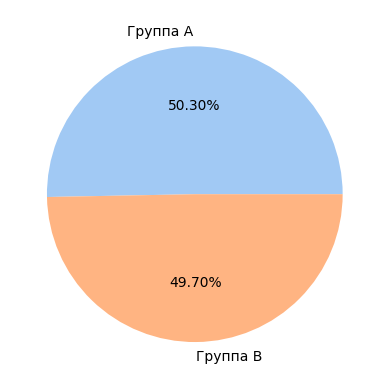

In [43]:
values = [ab_test[ab_test['Variant'] == 0].shape[0], ab_test[ab_test['Variant'] == 1].shape[0]]
colors = sns.color_palette('pastel')
#create pie chart
plt.pie(values, labels=['Группа А', 'Группа В'], colors = colors, autopct='%.2f%%')
plt.show()
    

**Посмотрим сколько регистраций и оплат было совершено в каждой группе.**

In [13]:
data_grouped = ab_test.groupby('Variant').agg({
    'Users':'count',
    'ga:goal18Completions':'sum'
}).reset_index().rename(columns={
    'Users': 'count_visits',
    'ga:goal18Completions': 'count_purchases'
})
data_grouped

,Variant,count_visits,count_purchases
0,0,116244,682
1,1,114843,705


**Добавим столбец с конверсией**

In [14]:
data_grouped['conversion'] = data_grouped['count_purchases'] / data_grouped['count_visits'] * 100
data_grouped

,Variant,count_visits,count_purchases,conversion
0,0,116244,682,0.586697
1,1,114843,705,0.613882


**Показатели очень близки. Для обеих групп конверсия составляет примерно 0,6%**

**Теперь оценим стабилизацию кумулятивных метрик во времени.**

In [15]:
data_grouped_cum = ab_test.groupby(['date', 'Variant']).agg({
    'Users':'count',
    'ga:goal18Completions':'sum'
}).reset_index().rename(columns={
    'Users': 'count_visits',
    'ga:goal18Completions': 'count_purchases'
})
data_grouped_cum['conversion'] = data_grouped_cum['count_purchases'] / data_grouped_cum['count_visits'] * 100
data_grouped_cum['cum_count_visits'] = data_grouped_cum.groupby(
    ['Variant'])['count_visits'].cumsum()
data_grouped_cum['cum_count_purchases'] = data_grouped_cum.groupby(
    ['Variant'])['count_purchases'].cumsum()
data_grouped_cum['cum_conversion'] = data_grouped_cum['cum_count_purchases'] / data_grouped_cum['cum_count_visits'] * 100

data_grouped_cum.head()

,date,Variant,count_visits,count_purchases,conversion,cum_count_visits,cum_count_purchases,cum_conversion
0,2022-10-13,0,2451,13,0.530396,2451,13,0.530396
1,2022-10-13,1,2481,19,0.765820,2481,19,0.765820
2,2022-10-14,0,4206,25,0.594389,6657,38,0.570828
3,2022-10-14,1,4303,31,0.720428,6784,50,0.737028
4,2022-10-15,0,3767,10,0.265463,10424,48,0.460476


**Визуализируем изменение кумулятивной метрики**

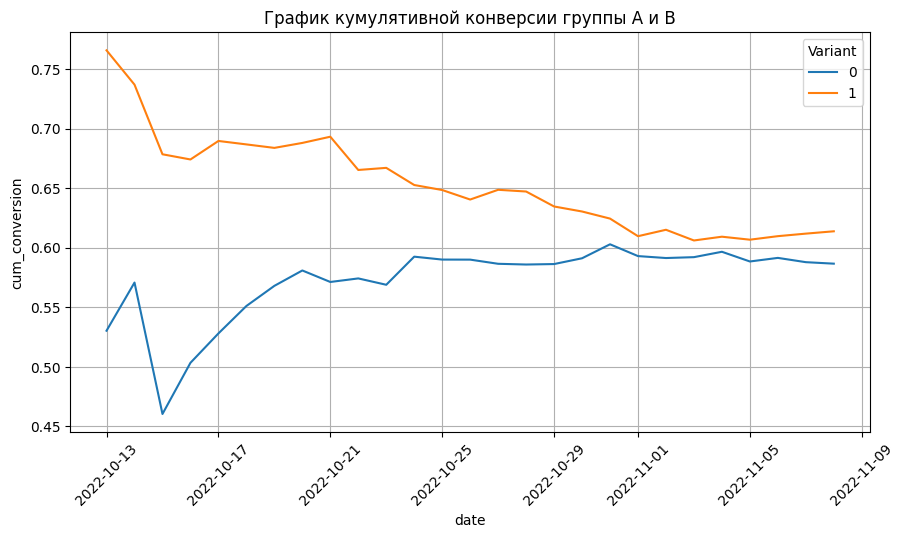

In [16]:
fig = plt.figure(figsize=[8, 4])
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=data_grouped_cum,
    x='date',
    y='cum_conversion',
    hue='Variant',
    ax=ax
)
ax.set_title('График кумулятивной конверсии группы А и В')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True);

**Заметим, что в группе В(1) метрика в начале эксперимента выше, чем в группе А(0), однако, после 1 ноября конверсия для обеих групп сравнялась.**


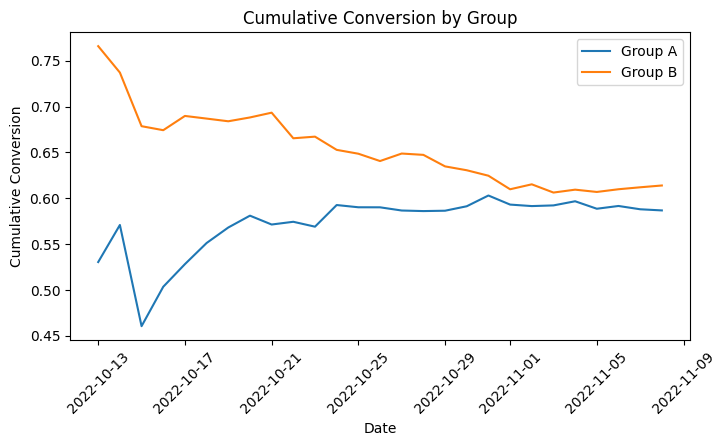

**Заметим, что в группе В(1) метрика в начале эксперимента выше, чем в группе А(0), однако, после 1 ноября конверсия для обеих групп сравнялась.**


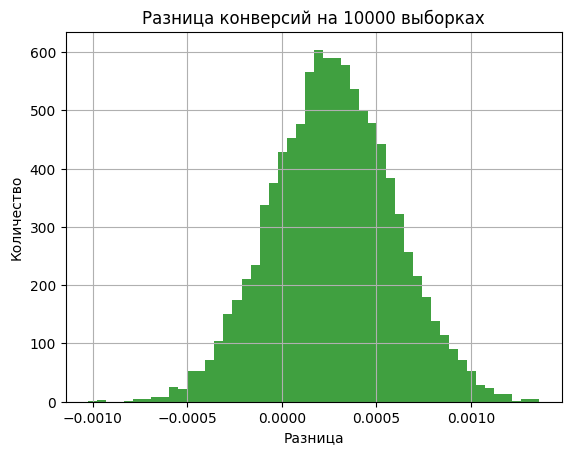

In [55]:
print('**Заметим, что в группе В(1) метрика в начале эксперимента выше, чем в группе А(0), однако, после 1 ноября конверсия для обеих групп сравнялась.**')

fig, ax = plt.subplots(figsize=[8, 4])

# plot data for group A
ax.plot(data_grouped_cum[data_grouped_cum['Variant'] == 0]['date'], 
        data_grouped_cum[data_grouped_cum['Variant'] == 0]['cum_conversion'], 
        label='Group A')

# plot data for group B
ax.plot(data_grouped_cum[data_grouped_cum['Variant'] == 1]['date'], 
        data_grouped_cum[data_grouped_cum['Variant'] == 1]['cum_conversion'], 
        label='Group B')

# set title and axis labels
ax.set_title('Cumulative Conversion by Group')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Conversion')

# rotate x-axis labels and add legend
plt.xticks(rotation=45)
ax.legend()

# display plot
plt.show()

print('**Заметим, что в группе В(1) метрика в начале эксперимента выше, чем в группе А(0), однако, после 1 ноября конверсия для обеих групп сравнялась.**')

plt.hist(x=conversion_diffs, bins=50, facecolor='g', alpha=0.75)
plt.grid(True)
plt.xlabel('Разница')
plt.ylabel('Количество')
plt.title('Разница конверсий на 10000 выборках');


**Заметим, что в группе В(1) метрика в начале эксперимента выше, чем в группе А(0), однако, после 1 ноября конверсия для обеих групп сравнялась.**

**Теперь перейдем к проверке статистической значимости метрик в обеих группах. Уровень значимости установим 0.05**

In [17]:
data_grouped

,Variant,count_visits,count_purchases,conversion
0,0,116244,682,0.586697
1,1,114843,705,0.613882


In [18]:
# для сравнения конверсий мы будем 
# использовать z-критерий для пропорций

H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05

_, p_value = proportions_ztest(
    count=data_grouped['count_purchases'],
    nobs=data_grouped['count_visits'], 
    alternative='two-sided'
)

print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.4
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


**Проведя Z-тест, мы получили p-value равное 0.79. Так как  уровень значимости $\alpha$ = 0.05, то мы приняли нулевую гипотезу о том, что конверсии равны. Поэтому статистическая значимость между конверсиями А и В отсутствует**

**Теперь убедимся в правильности выводов и построим 95% доверительный интервал**

In [19]:
group_a = ab_test[ab_test['Variant'] == 0]
group_b = ab_test[ab_test['Variant'] == 1]

In [20]:
def z_mean_conf_interval(n, x_mean, x_std, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * x_std / n**0.5 # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    return lower_bound, upper_bound

lower_bound_a, upper_bound_a = z_mean_conf_interval(
    group_a.shape[0], 
    group_a['ga:goal18Completions'].mean(),
    group_a['ga:goal18Completions'].std()
    )
# возвращаем кортеж из округлённых границ интервала для группы А
confidence_interval_a = (round(lower_bound_a, 4), round(upper_bound_a, 4))

lower_bound_b, upper_bound_b = z_mean_conf_interval(
    group_b.shape[0], 
    group_b['ga:goal18Completions'].mean(),
    group_b['ga:goal18Completions'].std()
    )
# возвращаем кортеж из округлённых границ интервала для группы В
confidence_interval_b = (round(lower_bound_b, 4), round(upper_bound_b, 4))

print(f'Доверительный интервал группы А: {confidence_interval_a}')
print(f'Доверительный интервал группы B: {confidence_interval_b}')

Доверительный интервал группы А: (0.0054, 0.0063)
Доверительный интервал группы B: (0.0057, 0.0066)


**Также построим доверительный интервал для разности конверсий**


In [21]:
def diff_proportions_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [group_a.shape[0], group_b.shape[0]]
# выборочная пропорция групп A и B
x_p = [group_a['ga:goal18Completions'].mean(), group_b['ga:goal18Completions'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, x_p)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.04, 0.09)


**Интервал охватывает точку 0. Левая граница доверительного интервала
отрицательная, а правая — положительная. То есть истинная разница в
пропорциях ∆𝑝 = 𝑝𝑏 − 𝑝𝑎 может быть как положительной, так и отрицательной.
Это значит, что пропорция А равна пропорции B.**

## **Бустреп**

**Оценим конверсии и найдем доверительные интервалы для разниц конверсий, сгенерировав 10000 подвыборок.**

In [22]:
conversion_a = [] # создадим пустой список, куда будем вносить значения конверсии А
conversion_b = [] # создадим пустой список, куда будем вносить значения конверсии В
conversion_diffs = [] # создадим пустой список, куда будем вносить значения разности

for _ in range(10000): # запускаем цикл на 10000 итераций
    # создаем подвыборку для группы А с таким же размером
    sample_a = np.random.binomial(
        1, 
        group_a['ga:goal18Completions'].mean(), 
        group_a.shape[0]
        )
    # создаем подвыборку для группы В с таким же размером
    sample_b = np.random.binomial(
        1, 
        group_b['ga:goal18Completions'].mean(), 
        group_b.shape[0]
        )
    sample_a_mean = sample_a.mean() # считаем конверсию группы А
    sample_b_mean = sample_b.mean() # считаем конверсию группы B
    conversion_a.append(sample_a_mean) # сохраняем в список
    conversion_b.append(sample_b_mean) # сохраняем в список
    # находим разницу конверсий и добавляем ее в список
    conversion_diffs.append(sample_b_mean - sample_a_mean)
    
# размеры выборок групп А и B
n = [group_a.shape[0], group_b.shape[0]]
# выборочная пропорция групп A и B
x_p = [np.average(conversion_a), np.average(conversion_b)]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, x_p)
has_effect = not (diff_inverval[0] < 0 < diff_inverval[1])
print(f'Значение конверсии изменилось на: {(np.average(conversion_diffs)*100):0.3f}%')
print(f'95% доверительный интервал: ({diff_inverval[0]}, {diff_inverval[1]})')
print(f'Отличия статистически значимые: {has_effect}')
    

Значение конверсии изменилось на: 0.027%
95% доверительный интервал: (-0.04, 0.09)
Отличия статистически значимые: False


In [23]:
conversion_a = [] # создадим пустой список, куда будем вносить значения конверсии А
conversion_b = [] # создадим пустой список, куда будем вносить значения конверсии В
conversion_diffs = [] # создадим пустой список, куда будем вносить значения разности

for _ in range(10000): # запускаем цикл на 10000 итераций
    # создаем подвыборку для группы А с таким же размером
    sample_a = np.random.choice(
        group_a['ga:goal18Completions'],
        group_a.shape[0],
        replace=True
        )
    # создаем подвыборку для группы В с таким же размером
    sample_b = np.random.choice(
        group_b['ga:goal18Completions'],
        group_b.shape[0],
        replace=True
        )
    sample_a_mean = sample_a.mean() # считаем конверсию группы А
    sample_b_mean = sample_b.mean() # считаем конверсию группы B
    conversion_a.append(sample_a_mean) # сохраняем в список
    conversion_b.append(sample_b_mean) # сохраняем в список
    # находим разницу конверсий и добавляем ее в список
    conversion_diffs.append(sample_b_mean - sample_a_mean)
    
# размеры выборок групп А и B
n = [group_a.shape[0], group_b.shape[0]]
# выборочная пропорция групп A и B
x_p = [np.average(conversion_a), np.average(conversion_b)]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, x_p)
has_effect = not (diff_inverval[0] < 0 < diff_inverval[1])
print(f'Значение конверсии изменилось на: {(np.average(conversion_diffs)*100):0.3f}%')
print(f'95% доверительный интервал: ({diff_inverval[0]}, {diff_inverval[1]})')
print(f'Отличия статистически значимые: {has_effect}')

Значение конверсии изменилось на: 0.027%
95% доверительный интервал: (-0.04, 0.09)
Отличия статистически значимые: False


**Мы снова подтвердили, что изменение конверсии статистически не значимо.**

Построим гистограмму распределения разницы конверсий****

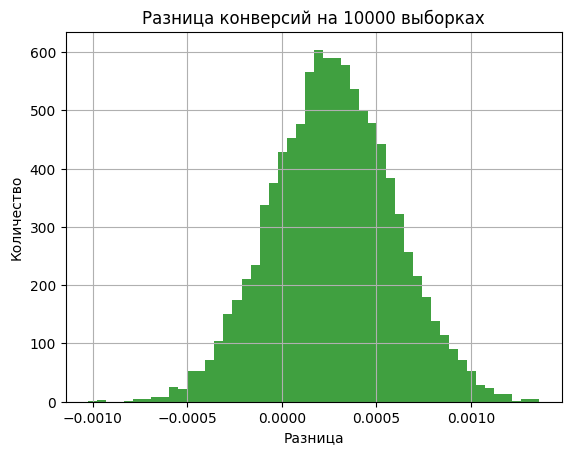

In [52]:
plt.hist(x=conversion_diffs, bins=50, facecolor='g', alpha=0.75)
plt.grid(True)
plt.xlabel('Разница')
plt.ylabel('Количество')
plt.title('Разница конверсий на 10000 выборках');

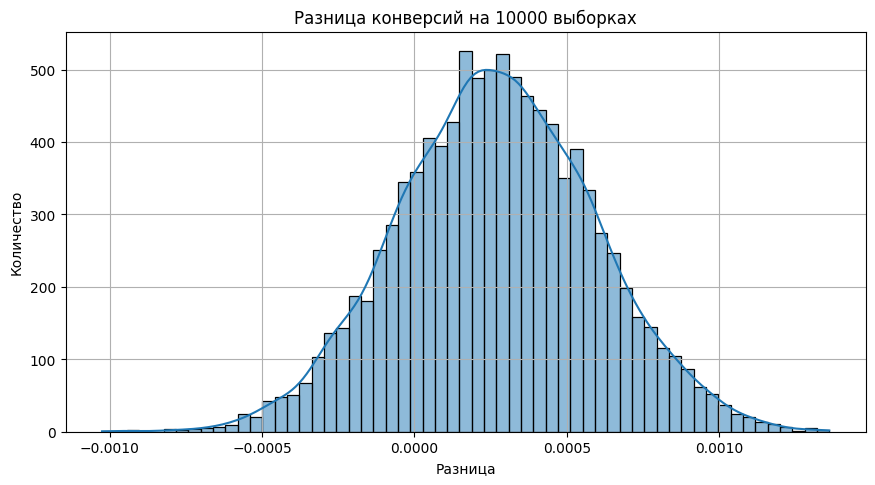

In [24]:
fig = plt.figure(figsize=[8, 4])
ax = fig.add_axes([1, 1, 1, 1])
sns.histplot(
    data=conversion_diffs,
    kde=True,
    ax=ax
)

ax.set_title('Разница конверсий на 10000 выборках')
ax.set_xlabel('Разница')
ax.set_ylabel('Количество')
ax.grid(True);

## Вывод

**- Изменение конверсии в тестовой группе В статистически не значимо. Рекомендуется остаться на текущей версии продукта (группа А).**